In [31]:
%load_ext autoreload
%autoreload 2

In [1]:
import os, random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow import keras
from keras.utils.np_utils import to_categorical
from keras.utils import Progbar

from util import *

seed = 42
plt.rc('font', size=8)
plt.rc('axes', titlesize=8)
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2023-05-30 16:56:34.865197: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-30 16:56:36.100398: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

seed_everything(seed)

## Extracting relevant features

Since, the dataset contains a lot of information we decided to use only u smal subset of features

In [34]:
data = pd.read_parquet("data/job_table.parquet")
print(f"Number of features: {len(data.columns)}")

In [ ]:
# defining sets of data
columns = ["submit_time", "user_id", "group_id", "name", "command", "partition", "cpus_per_task",
           "num_cpus", "num_nodes", "num_tasks", "priority", "qos", "req_nodes", "time_limit",
           "tres_req_str", "year_month", "cpus_per_tres", "dependency", "ntasks_per_socket", "job_state"]
df = data[columns]
df = df[df.tres_req_str != ""]
df = df[(df.job_state != "CANCELLED") & (df.job_state != "NODE_FAIL")]
df.reset_index(drop=True, inplace=True)
df

In [ ]:
df.describe()

## Data selection

As first thing, try to understand how many missing values we had in the dataset

In [ ]:
df = df.replace('', np.nan)
print(df.isna().sum(axis=0))
prev_len = len(df)
print(f"Num of rows: {len(df)}")

As you can see *req_nodes*, *cpus_per_tres*, *dependency*, *ntasks_per_socket* are mostly NaN in this subset, so re drop that columns for the moment. For the other columns, as first thing let's remove all the rows that contains at least one NaN.

In [ ]:
df = df.drop(["req_nodes", "cpus_per_tres", "dependency", "ntasks_per_socket"], axis=1)
df = df.dropna().reset_index(drop=True)
print(df.isna().sum(axis=0))
print(f"Num of rows: {len(df)}")
print(f"Dropped rows: {prev_len - len(df)} ({(1-(len(df)/prev_len))*100:.1f} %)")

Set time zone to None

In [ ]:
df["submit_time"] = df["submit_time"].dt.tz_localize(None)

Save as pickle for more efficent usage

In [ ]:
df.to_pickle("data/job_table_reduced.pkl")

## Data fixing

In [ ]:
df =pd.read_pickle("data/job_table_reduced.pkl")
df["job_state"] = df["job_state"].astype(object)
df.head()

Let's inspect how data are

In [ ]:
df.dtypes

As you can see, a lot of data are string and these are difficult to use. So, try to convert it into better format

Start with those data types that are category

In [ ]:
cat_columns = df.select_dtypes(["category"]).columns
ord_enc =  OrdinalEncoder(dtype=np.int64)
for col in cat_columns:
    val = df[col].values.reshape(-1, 1)
    df[col] = ord_enc.fit_transform(val)
print(f"Categorical columns transformed: {cat_columns.values}")
print()
print(df.dtypes)

In [ ]:
df.head()

Now categorical data are in right format, move to integer columns.

In [ ]:
int_columns = ["user_id", "group_id", "cpus_per_task", "num_cpus", "num_nodes", "num_tasks", "priority", "time_limit"]
for col in int_columns:
    print(f"Check if all {col} are number: {all([item.isdigit() for item in df[col].unique()])}")

df[int_columns] = df[int_columns].apply(pd.to_numeric)
print()
print(df.dtypes)

for the moment ignore allocated value

In [ ]:
df = df.drop(["num_cpus", "num_nodes"], axis=1)

In [ ]:
df.head()

Now, it's time for *name* and *command*, we will try different approach for these two columns. Now, start with the basic one and use and Integer Encodig.

In [ ]:
string_columns = ["name", "command"]
ord_enc =  OrdinalEncoder(dtype=np.int64)
for col in string_columns:
    val = df[col].values.reshape(-1, 1)
    df[col] = ord_enc.fit_transform(val)
print(df.dtypes)

Now, for the *tres_req_str* we decide to split this column into 5 different columns

In [ ]:
# key = list(set([elem.split("=")[0] for row in df['tres_req_str'] for elem in row.split(",")]))
key = ['req_cpu', 'req_mem', 'req_node', 'req_billing', 'req_gres/gpu']
df["tres_req_str"] = df["tres_req_str"].apply(lambda row: ",".join([v.split("=")[1] for v in row.split(",")]))
df[key] =  df['tres_req_str'].str.split(",", expand=True)
df['req_mem'] = df['req_mem'].str.extract('(\d+)')
df = df.drop(["tres_req_str"], axis=1)
df[key] = df[key].fillna(0)
df[key] = df[key].astype(np.int64)

In [ ]:
df

In [ ]:
df.dtypes

## Data Anlaysis

In [ ]:
df = pd.read_pickle("data/job_table_r_preproc.pkl")
df.head()

,submit_time,user_id,group_id,name,command,partition,cpus_per_task,num_tasks,priority,qos,time_limit,year_month,req_cpu,req_mem,req_node,req_billing,req_gres/gpu,job_state
0,2020-05-22 01:06:05,32171,25200,77949,62668,3,4,1,87034,4,10,0,4,246000,1,4,0,COMPLETED
1,2020-05-22 01:06:10,32171,25200,77949,62782,3,4,1,85884,4,10,0,4,246000,1,4,0,COMPLETED
2,2020-05-22 01:05:39,32171,25200,77949,62085,3,4,1,115982,4,10,0,4,246000,1,4,0,COMPLETED
3,2020-05-22 18:56:39,32152,25200,30918,51406,3,32,8,80216,4,360,0,256,230000,1,256,1,FAILED
4,2020-05-22 01:06:06,32171,25200,77949,62678,3,4,1,86934,4,10,0,4,246000,1,4,0,COMPLETED


In [ ]:
df.describe()

,user_id,group_id,name,command,partition,cpus_per_task,num_tasks,priority,qos,time_limit,year_month,req_cpu,req_mem,req_node,req_billing,req_gres/gpu
count,975170.000000,975170.000000,975170.000000,975170.000000,975170.000000,975170.000000,975170.000000,9.751700e+05,975170.000000,975170.000000,975170.000000,975170.000000,9.751700e+05,975170.000000,975170.000000,975170.000000
mean,29594.175688,25199.469359,52860.272143,81735.783514,2.979162,13.301554,16.523853,2.174448e+05,3.983316,1063.603737,3.086999,114.862959,9.824398e+04,1.724648,114.862959,4.596272
std,3018.851460,428.234467,22232.066098,49709.961776,0.240188,16.250140,160.926988,1.016284e+06,0.373767,511.217883,1.678490,621.956853,5.347606e+05,7.200674,621.956853,27.519665
min,25261.000000,915.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000,1.000000,1.000000e+00,1.000000,1.000000,0.000000
25%,25278.000000,25200.000000,28575.000000,54249.250000,3.000000,1.000000,4.000000,1.493470e+05,4.000000,720.000000,1.000000,4.000000,2.370000e+02,1.000000,4.000000,0.000000
50%,31392.000000,25200.000000,64266.000000,77350.000000,3.000000,2.000000,4.000000,2.326160e+05,4.000000,1440.000000,4.000000,24.000000,8.000000e+03,1.000000,24.000000,1.000000
75%,32303.000000,25200.000000,77215.000000,77665.000000,3.000000,32.000000,24.000000,2.958820e+05,4.000000,1440.000000,5.000000,128.000000,8.600000e+04,1.000000,128.000000,4.000000
max,37202.000000,53925.000000,78585.000000,238767.000000,3.000000,4444.000000,32768.000000,1.000000e+09,7.000000,1440.000000,5.000000,65536.000000,5.796000e+07,256.000000,65536.000000,1024.000000


COMPLETED        0.879829
FAILED           0.101628
TIMEOUT          0.014265
OUT_OF_MEMORY    0.004277
Name: job_state, dtype: float64


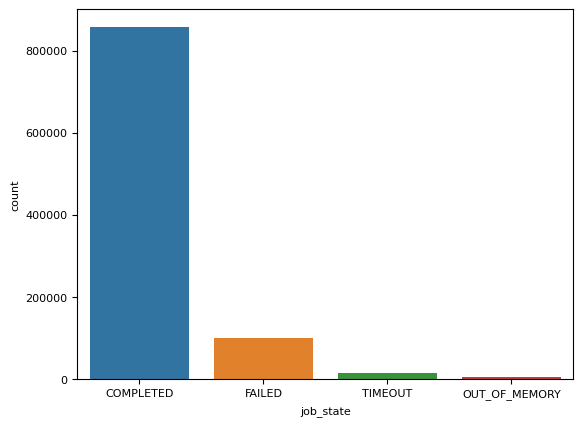

In [ ]:
sns.countplot(x=df["job_state"])
print(df.job_state.value_counts(normalize=True))

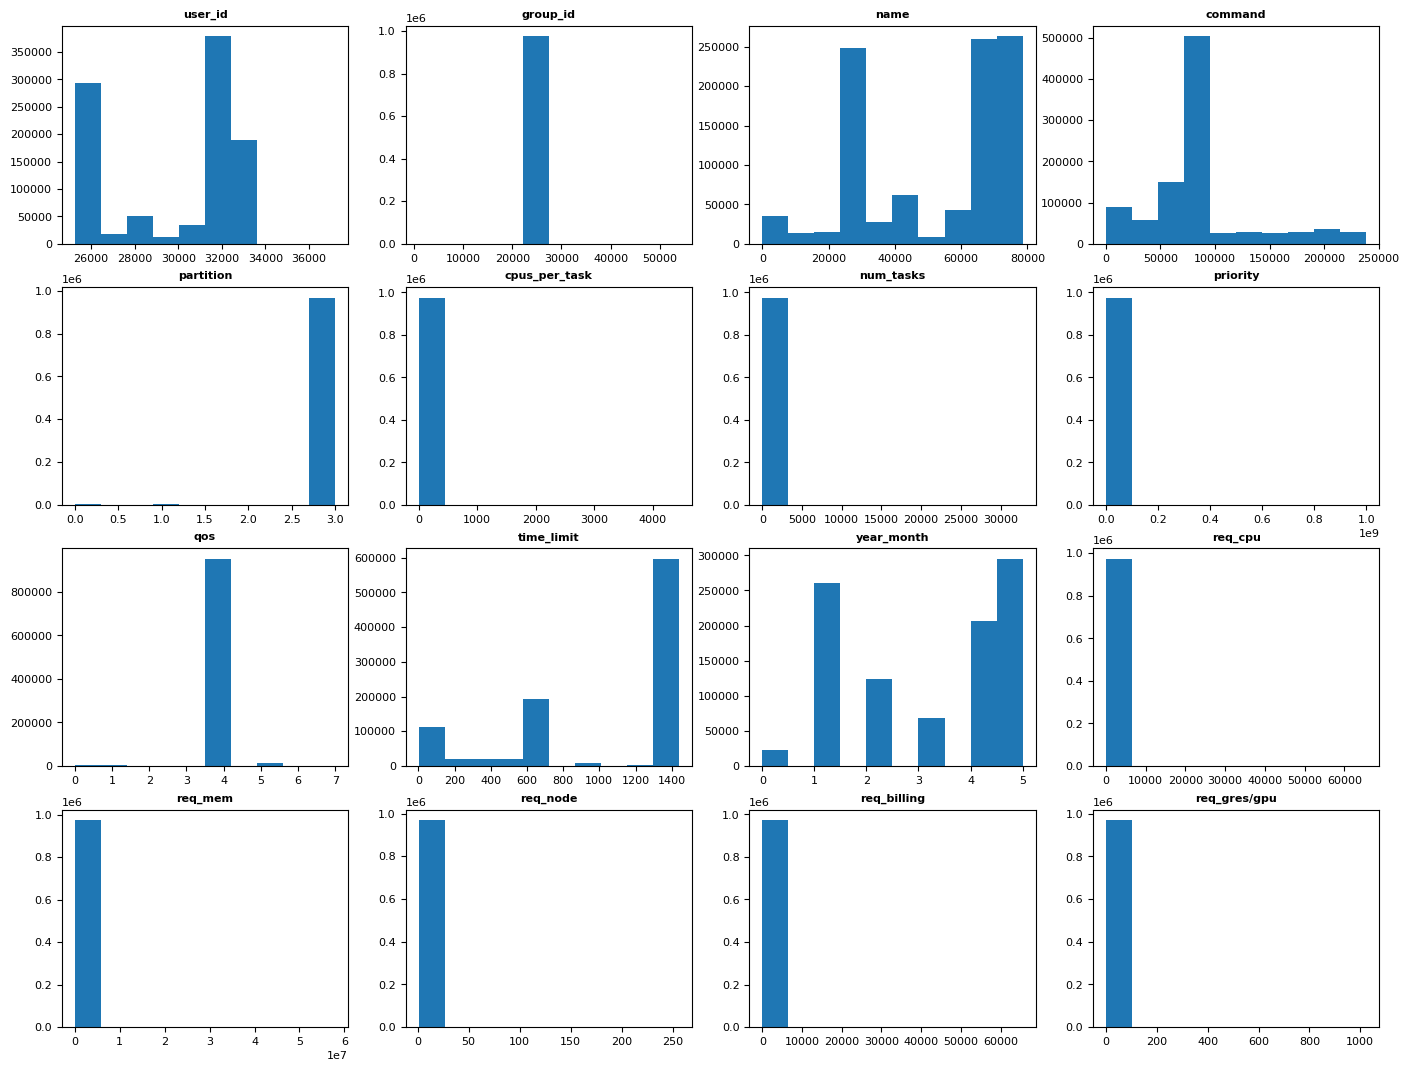

In [ ]:
cols = df.select_dtypes(include="int64").columns
fig, axs = plt.subplots(4, 4, figsize=(17, 13))
i, j = 0, 0
for col in cols:
    axs[i, j].hist(df[col])
    axs[i, j].set_title(col, fontweight="bold")
    j+=1
    if j%4 == 0:
        j = 0
        i +=1

156
req_cpu
128      0.314503
4        0.214987
24       0.201642
16       0.070772
1        0.045942
           ...   
540      0.000001
45       0.000001
65536    0.000001
496      0.000001
5376     0.000001
Name: proportion, Length: 156, dtype: float64


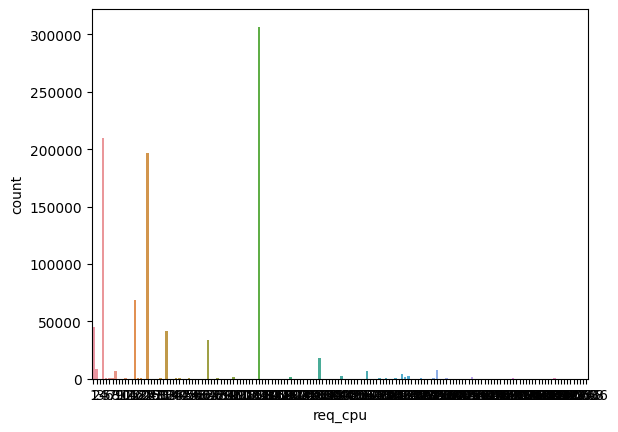

In [ ]:
sns.countplot(x=df[""])
print(len(df.req_cpu.unique()))
print(df.req_cpu.value_counts(normalize=True))

<Axes: >

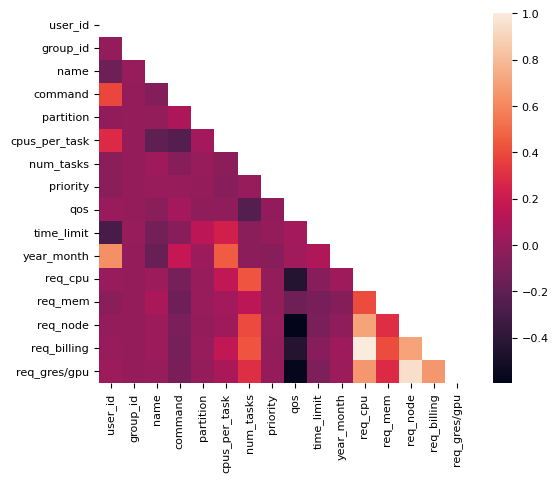

In [ ]:
df_corr = df.drop(["job_state", "submit_time"], axis=1)
corr_matrix=df_corr.corr()
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_matrix, mask=mask, square=True)

Inspect unique column values to better understand how it's usefull for exit status detection. Now we only consider binary case for semplicity were job are or Completed or Failed

In [ ]:
df_bin = df.drop(["submit_time"], axis=1)
df_bin["job_state"] = df_bin["job_state"].replace({"OUT_OF_MEMORY": "FAILED", "TIMEOUT": "FAILED"})
df_bin["job_state"] = df_bin["job_state"].replace({"COMPLETED": 0, "FAILED": 1}).astype(np.int64)

for col in df_bin.select_dtypes(include="int").columns:
    print(f"{col} unique values: {len(df_bin[col].unique())}")

user_id unique values: 510
group_id unique values: 6
name unique values: 78586
command unique values: 238768
partition unique values: 4
cpus_per_task unique values: 34
num_tasks unique values: 115
priority unique values: 86357
qos unique values: 8
time_limit unique values: 355
year_month unique values: 6
req_cpu unique values: 156
req_mem unique values: 505
req_node unique values: 62
req_billing unique values: 156
req_gres/gpu unique values: 71
job_state unique values: 2


Now excluding *command* feature which has to much unique values, plot hist plot

<Axes: xlabel='req_gres/gpu', ylabel='Count'>

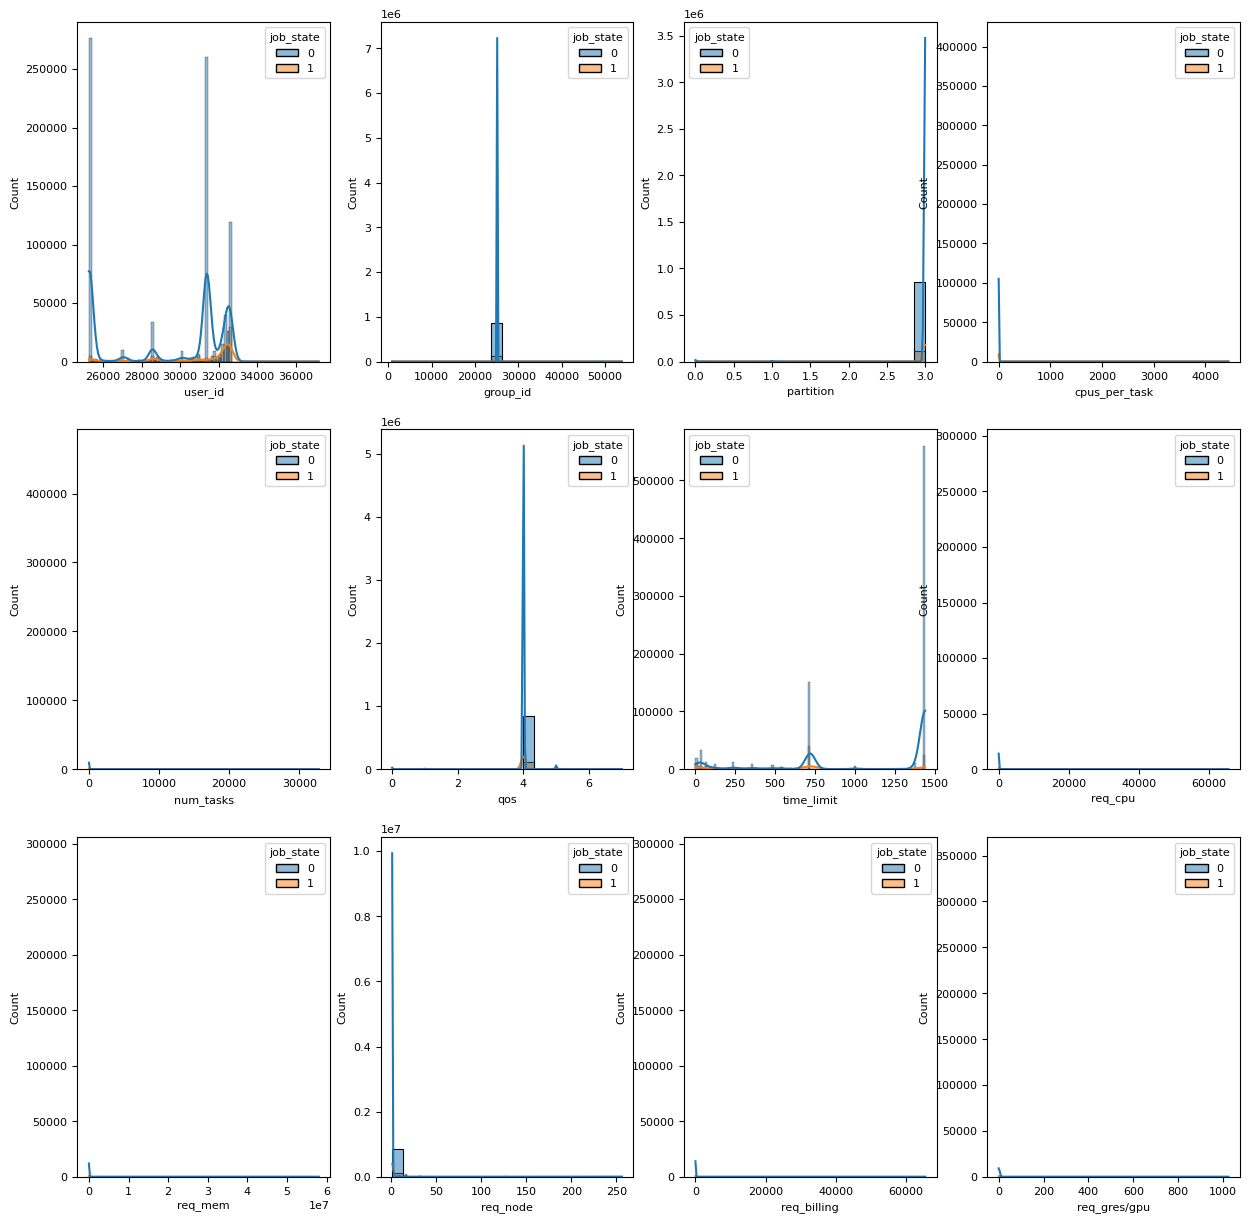

In [ ]:
print_col = set(df_bin.columns).difference(set(["command", "job_state", "name", "priority"]))
fig, axs = plt.subplots(3, 4, figsize=(15, 15))

sns.histplot(data=df_bin, x="user_id", hue="job_state", kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=df_bin, x="group_id", hue="job_state", kde=True, color="skyblue", ax=axs[0, 1])
sns.histplot(data=df_bin, x="partition", hue="job_state", kde=True, color="skyblue", ax=axs[0, 2])
sns.histplot(data=df_bin, x="cpus_per_task", hue="job_state", kde=True, color="skyblue", ax=axs[0, 3])
sns.histplot(data=df_bin, x="num_tasks", hue="job_state", kde=True, color="skyblue", ax=axs[1, 0])
sns.histplot(data=df_bin, x="qos", hue="job_state", kde=True, color="skyblue", ax=axs[1, 1])
sns.histplot(data=df_bin, x="time_limit", hue="job_state", kde=True, color="skyblue", ax=axs[1, 2])
sns.histplot(data=df_bin, x="req_cpu", hue="job_state", kde=True, color="skyblue", ax=axs[1, 3])
sns.histplot(data=df_bin, x="req_mem", hue="job_state", kde=True, color="skyblue", ax=axs[2, 0])
sns.histplot(data=df_bin, x="req_node", hue="job_state", kde=True, color="skyblue", ax=axs[2, 1])
sns.histplot(data=df_bin, x="req_billing", hue="job_state", kde=True, color="skyblue", ax=axs[2, 2])
sns.histplot(data=df_bin, x="req_gres/gpu", hue="job_state", kde=True, color="skyblue", ax=axs[2, 3])

# i, j = 0, 0
# for col in print_col:
#     sns.histplot(data=df_bin, x=col, hue="job_state", kde=True, color="skyblue", ax=axs[i, j])
#     j+=1
#     if j%4 == 0:
#         i+=1
#         j=0

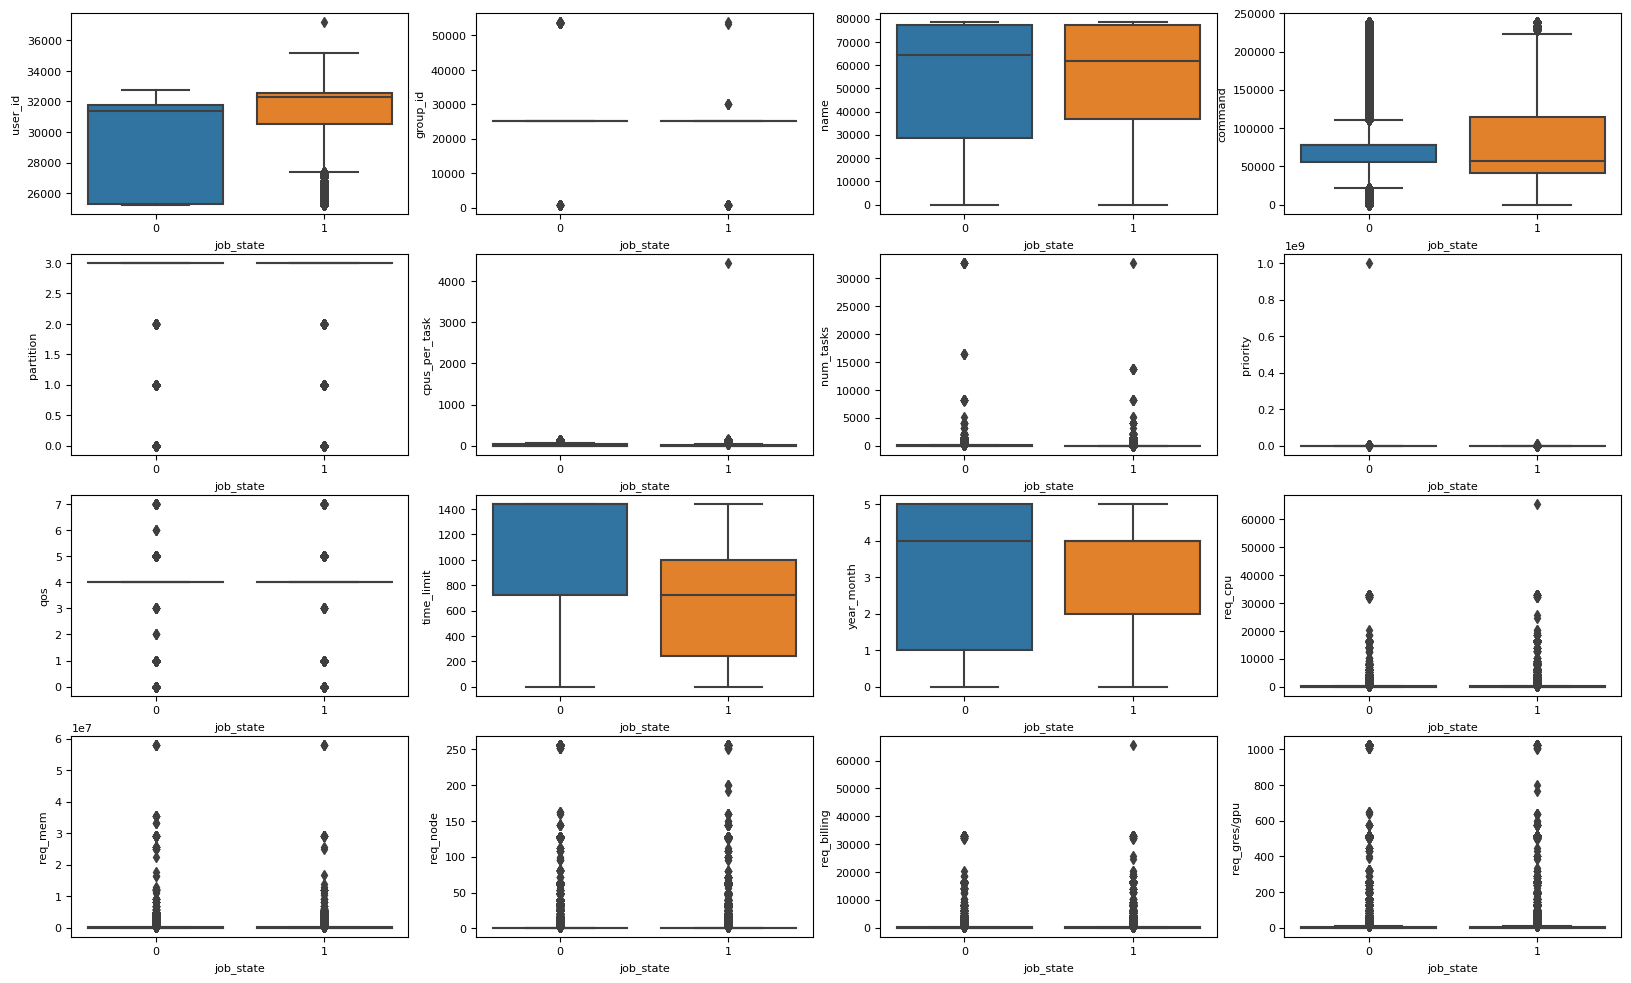

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(20, 12))

i, j = 0, 0
for col in df_bin.columns:
    if col != "job_state":
        sns.boxplot(x=df_bin["job_state"], y=df_bin[col], ax=axs[i, j])
        j+=1
        if j%4 == 0:
            i+=1
            j=0

## Exit state prediction

As first attempt we only consider 2 classes:
 - **0**: for completed job
 - **1**: for those failed
 
To do so, we firstly convert other failure classes into **FAILED**.

In [3]:
def get_data(path):
    df = pd.read_pickle("data/job_table_r_preproc.pkl")
    labels = df["job_state"]
    df = df.drop(["job_state", "submit_time"], axis=1)
    return df.to_numpy(), labels.to_numpy()

print("Loading data... ", end="")
data, labels = get_data("data/job_table_r_preproc.pkl")
print("Lodaded!")
print()
print("Old labels: ", np.unique(labels))

labels[labels == "OUT_OF_MEMORY"] = "FAILED"
labels[labels == "TIMEOUT"] = "FAILED"

print("New labels: ", list(np.unique(labels)))

Loading data... Lodaded!

Old labels:  ['COMPLETED' 'FAILED' 'OUT_OF_MEMORY' 'TIMEOUT']
New labels:  ['COMPLETED', 'FAILED']


Encode labels

In [4]:
lab_enc = LabelEncoder()
lab_enc.fit(labels)
unique_labels = lab_enc.classes_
num_classes = len(unique_labels)

print(f"Old values: {labels[:5]}")
labels = lab_enc.transform(labels)
print(f"New values: {labels[:5]}")

Old values: ['COMPLETED' 'COMPLETED' 'COMPLETED' 'FAILED' 'COMPLETED']
New values: [0 0 0 1 0]


Split the data into train, validation and test sets and normalize using only train information

In [5]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, train_size=0.7, random_state=seed)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.8, random_state=seed)

x_train_mean = x_train.mean()
x_train_std = x_train.std()
x_train = (x_train - x_train_mean) / x_train_std
x_val = (x_val - x_train_mean) / x_train_std
x_test = (x_test - x_train_mean) / x_train_std

print(f"train data shape: {x_train.shape}")
print(f"val data shape: {x_val.shape}")
print(f"test data shape: {x_test.shape}")
print(f"train labels shape: {len(y_train)}")
print(f"val labels shape: {len(y_val)}")
print(f"test labels shape: {len(y_test)}")

train data shape: (546095, 16)
val data shape: (136524, 16)
test data shape: (292551, 16)
train labels shape: 546095
val labels shape: 136524
test labels shape: 292551


### Using a NN

Build the model

In [6]:
def build_model(input_shape, output_shape, hiddens):
    model_in = keras.Input(shape=input_shape)
    x = model_in
    for h in hiddens:
        x = keras.layers.Dense(h, activation='relu')(x)
    x = keras.layers.Dropout(0.3)(x)
    model_out = keras.layers.Dense(output_shape, activation="sigmoid")(x)
    model = keras.Model(model_in, model_out)
    return model

In [ ]:
model = build_model((None, x_train.shape[1], ), 1, hiddens=[128, 128])
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.Adam(), 
              metrics=["accuracy"])
model.summary()

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(x_train, y_train, epochs=50, validation_split=0.2, batch_size=256, callbacks=[callback])
plot_training_history(history)

In [ ]:
y_pred = model.predict(x_test, batch_size=1024)
y_pred = tf.reshape(y_pred, y_pred.shape[0]).numpy()
y_pred = np.where(y_pred < 0.5, 0, 1)

# Create the confusion matrix
cm_nn = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm_nn).plot()

f1 = f1_score(y_test, y_pred, average="binary")
print(f"F1 on test set: {f1}")

Weight the the loss function

In [7]:
class WeightDecayBCE(keras.losses.Loss):
    def __init__(self, weights, from_logits=False,
                 reduction=keras.losses.Reduction.AUTO,
                 name='weighted_decay_bce'):
        super().__init__(reduction=reduction, name=name)
        self.weights = weights
        self.from_logits = from_logits

    def call(self, y_true, y_pred):
        weights_v = tf.where(tf.equal(y_true, 1), self.weights[1], self.weights[0])
        weights_v = tf.cast(weights_v, dtype=tf.float32)
        bce = keras.backend.binary_crossentropy(y_true, y_pred, from_logits=self.from_logits)
        loss = keras.backend.mean(tf.multiply(bce, weights_v))
        return loss

In [8]:
weights = class_weight.compute_class_weight(class_weight='balanced',
                                            classes=np.unique(y_train),
                                            y=y_train)
weighted_bce = WeightDecayBCE(weights)

model2 = build_model((None, x_train.shape[1], ), 1, hiddens=[128, 128])
model2.compile(loss=weighted_bce,
              optimizer=keras.optimizers.Adam(), 
              metrics=["accuracy"])
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 16)]        0         
                                                                 
 dense (Dense)               (None, None, 128)         2176      
                                                                 
 dense_1 (Dense)             (None, None, 128)         16512     
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 dense_2 (Dense)             (None, None, 1)           129       
                                                                 
Total params: 18,817
Trainable params: 18,817
Non-trainable params: 0
_________________________________________________________________


2023-05-30 16:56:54.297982: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9854 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:08:00.0, compute capability: 6.1


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history2 = model2.fit(x_train, y_train, epochs=50, validation_split=0.2, batch_size=256, callbacks=[callback])
plot_training_history(history2)

In [9]:
model2.load_weights("checkpoints/tabMLP_wbce.h5")

2023-05-30 16:57:05.106991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [292551,16]
	 [[{{node Placeholder/_10}}]]
2023-05-30 16:57:05.107334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [292551,16]
	 [[{{node Placeholder/_10}}]]


286/286 [==============================] - 1s 1ms/step
F1 on test set: 0.5696684645075535
Recall on test set: 0.9587300676838362
Precision on test set: 0.4052245590641857



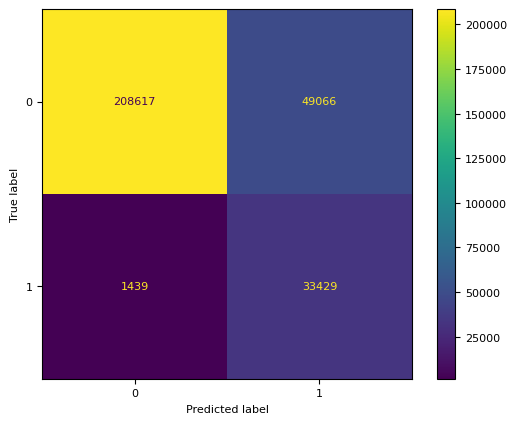

In [10]:
y_pred = model2.predict(x_test, batch_size=1024)
y_pred = tf.reshape(y_pred, y_pred.shape[0]).numpy()
y_pred = np.where(y_pred < 0.5, 0, 1)

# Create the confusion matrix
cm_nn = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm_nn).plot()

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")
print(f"F1 on test set: {f1}")
print(f"Recall on test set: {recall}")
print(f"Precision on test set: {precision}")
print()

#### Test classes

In [8]:
class WeightDecayBCE(keras.losses.Loss):
    def __init__(self, weights, from_logits=False,
                 reduction=keras.losses.Reduction.AUTO,
                 name='weighted_decay_bce'):
        super().__init__(reduction=reduction, name=name)
        self.weights = weights
        self.from_logits = from_logits

    def call(self, y_true, y_pred):
        weights_v = tf.where(tf.equal(y_true, 1), self.weights[1], self.weights[0])
        weights_v = tf.cast(weights_v, dtype=tf.float32)
        bce = keras.backend.binary_crossentropy(y_true, y_pred, from_logits=self.from_logits)
        loss = keras.backend.mean(tf.multiply(bce, weights_v))
        return loss

In [9]:
class TabMLP(keras.Model):
    def __init__(self, output_shape=1, binary_task=True):
        super(TabMLP, self).__init__()
        self.d1 = keras.layers.Dense(128, activation='relu')
        self.d2 = keras.layers.Dense(128, activation='relu')
        self.do = keras.layers.Dropout(0.3)
        self.classifier = keras.layers.Dense(output_shape, activation="sigmoid")

    def call(self, inputs):
        x = self.d1(inputs)
        x = self.d2(x)
        x = self.do(x)
        return self.classifier(x)

In [10]:
batch_size = 256

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

weights = class_weight.compute_class_weight(class_weight='balanced',
                                            classes=np.unique(y_train),
                                            y=y_train)
loss_fn = WeightDecayBCE(weights)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=x_train.shape[0]).batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(batch_size)

In [13]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        out = model(x, training=True)
        loss_value = loss_fn(y, tf.squeeze(out))
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return loss_value

@tf.function
def val_step(x, y):
    out = model(x, training=False)
    loss_value = loss_fn(y, tf.squeeze(out))
    return loss_value

@tf.function
def test_step(x):
    out = model(x, training=False)
    return out

In [ ]:
epochs = 30
train_length = len(train_dataset)
val_length = len(val_dataset)

model = TabMLP()

# Iterate over epochs.
for epoch in range(epochs):
    e_tloss = 0
    e_vloss = 0
    print(f"\nEpoch {epoch+1}/{epochs}")

    pb = Progbar(train_length+1, stateful_metrics=["train_loss", "val_loss"])

    # train loop
    for step, (inputs, labels) in enumerate(train_dataset):
        loss = train_step(inputs, labels)
        e_tloss += loss
        pb.add(1, values=[("train_loss",e_tloss/(step+1))])
        

    ## val loop
    for step, (inputs, labels) in enumerate(val_dataset):
        loss = val_step(inputs, labels)
        e_vloss += loss
    
    pb.add(1, values=[("val_loss",e_vloss/(step+1))])

In [18]:
model.load_weights("checkpoints/tabMLP_wbce.h5")

124/572 [=====>........................] - ETA: 0s

2023-05-30 16:49:20.450268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [292551,16]
	 [[{{node Placeholder/_10}}]]
2023-05-30 16:49:20.450483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [292551,16]
	 [[{{node Placeholder/_10}}]]


572/572 [==============================] - 1s 1ms/step
F1 on test set: 0.0


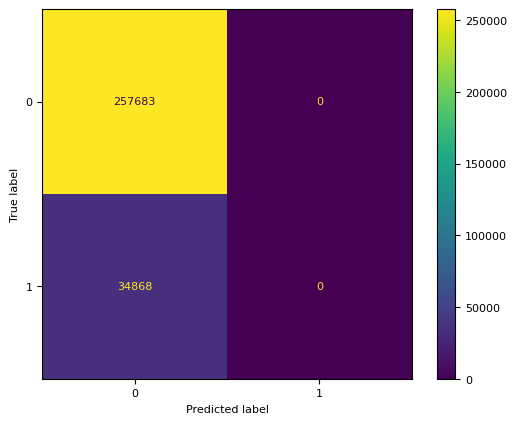

In [19]:
test_dataset = tf.data.Dataset.from_tensor_slices(x_test)
test_dataset = test_dataset.batch(batch_size)

pb = Progbar(len(test_dataset), stateful_metrics=[])
y_pred = model.predict(x_test, batch_size=512)

y_pred[y_pred < 0.5] = 0
y_pred[y_pred >= 0.5] = 0

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

f1 = f1_score(y_test, y_pred, average="binary")
print(f"F1 on test set: {f1}")

### ML Approach

In [11]:
# Create a random forest classifier
rf = RandomForestClassifier(random_state = seed)

rf.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [12]:
y_pred = rf.predict(x_test)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")
print(f"F1 on test set: {f1}")
print(f"Recall on test set: {recall}")
print(f"Precision on test set: {precision}")

F1 on test set: 0.8443142430351107
Recall on test set: 0.8348342319605369
Precision on test set: 0.8540120287516503



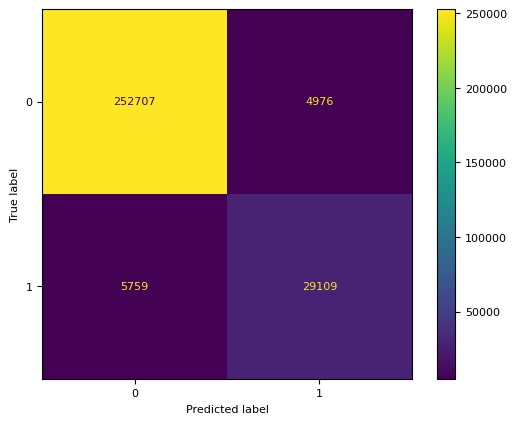

In [29]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [24]:
import xgboost as xgb

model = xgb.XGBClassifier(objective='binary:logistic',
                          booster='gbtree',
                          max_depth=6,
                          scale_pos_weight=0.7,
                          eval_metric="logloss",
                          seed=seed,
                          eta=0.1)
model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

F1 on test set: 0.6632287161287936


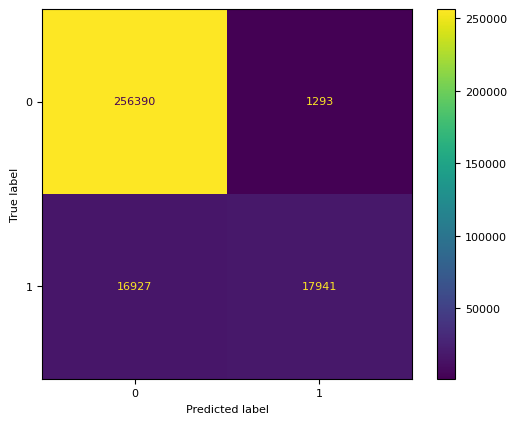

In [25]:
y_pred = model.predict(x_test)
f1 = f1_score(y_test, y_pred)
print("F1 on test set:", f1)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()